### overview

In [ ]:
'''
overview of training process:
    adverse -> depth    : (unet + disc) generator-discriminator
    
input -> encoder -> decoder -> discriminator -> output

overview of testing process:
    adverse -> depth
    
input -> (encoder -> decoder) -> output

'''

'\noverview of training process:\n    adverse -> depth    : (unet + disc) generator-discriminator\n    \ninput -> encoder -> decoder -> discriminator -> output\n\noverview of testing process:\n    adverse -> depth\n    \ninput -> (encoder -> decoder) -> output\n\n'

### imports

In [1]:
!pip install opencv-python-headless
!pip install albumentations==0.4.6
!pip install kornia
!pip install tensorboardX
!pip install numba
!pip install opencv-python; sudo apt-get update; sudo apt-get install ffmpeg libsm6 libxext6  -y;

  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.3 MB)
  Using cached albumentations-0.4.6-py3-none-any.whl
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached scikit_image-0.19.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  Using cached imageio-2.19.3-py3-none-any.whl (3.4 MB)
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
  Using cached Shapely-1.8.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.0 MB)
  Using cached tifffile-2022.5.4-py3-none-any.whl (195 kB)
  Using cached networkx-2.8.4-py3-none-any.whl (2.0 MB)
  Using cached PyWavelets-1.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.9 MB)
  Using cached kornia-0.6.5-py2.py3-none-any.whl (512 kB)
  Using cached tensorboardX-2.5.1-py2.py3-none-any.whl (125 kB)
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  

In [1]:
!rm -r evaluation/*
!rm -r checkpoints/*

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [1]:
import os
import time
import torch
import configs
import datetime
import torchvision
import matplotlib.cm
from math import exp
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable  
from utils import WeatherDepthDataset
# from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from utils import load_checkpoint, save_checkpoint, evaluate_model, colorize, ssim, upscale_depth_tensor, upscale_depth_img, DepthNorm, LogProgress
# from utils import both_transform, transform_only_input, transform_only_mask, DEVICE

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

torch.backends.cudnn.benchmark = True
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline


### visualizations

In [3]:
!rm -r runs/*

### check dataloaders

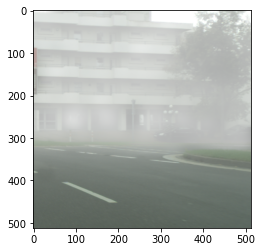

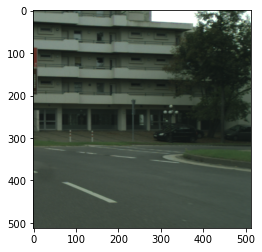

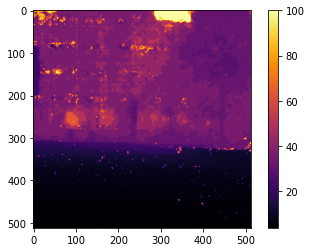

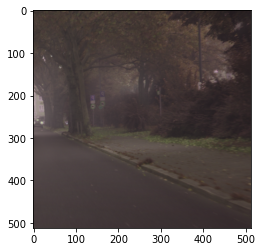

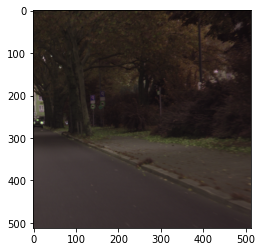

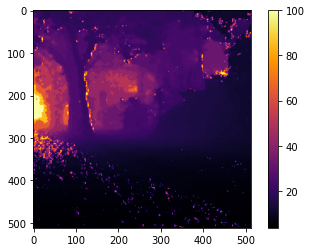

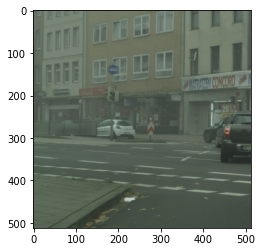

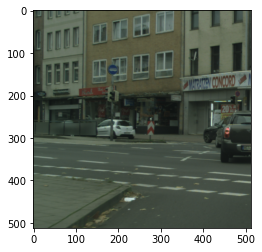

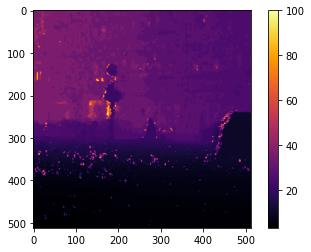

<Figure size 432x288 with 0 Axes>

In [2]:
dataset = WeatherDepthDataset(csv_file=configs.TRAIN_CSV ,root_dir=configs.ROOT_DIR, is_train=True)
loader = DataLoader(dataset, batch_size=1)

# print(len(loader))
i = 0
for sample in loader:

  plt.imshow(torch.squeeze(sample['image']).permute(1, 2, 0))
  plt.figure()

  plt.imshow(torch.squeeze(sample['clear']).permute(1, 2, 0))
  plt.figure()

  plt.imshow(torch.squeeze(DepthNorm(sample['depth'])), cmap=configs.CMAP_STYLE)
  plt.colorbar()
  plt.figure()

  i += 1
  if (i > 2):
    break

### models

In [3]:
######################## DISCRIMINATOR ########################

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
            )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_0 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
            )
        self.block_1 = CNNBlock(in_channels=64, out_channels=128, stride=2)
        self.block_2 = CNNBlock(in_channels=128, out_channels=256, stride=2)
        self.block_3 = CNNBlock(in_channels=256, out_channels= 512, stride=1)
        self.block_4 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')


    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x_0 = self.block_0(x)
        x_1 = self.block_1(x_0)
        x_2 = self.block_2(x_1)
        x_3 = self.block_3(x_2)
        x_4 = self.block_4(x_3)
        return x_4

def test():
    x = torch.randn((1, 3, 512, 512))
    y = torch.randn((1, 1, 512, 512))
    model = Discriminator()
    preds = model(x, y)
    # print(model)
    print(preds.shape)
    
test()


torch.Size([1, 1, 62, 62])


In [4]:
######################## ENCODER ########################

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        self.original_model = models.densenet169( pretrained=False )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features
    

In [5]:
######################## DECODER ########################

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1664, decoder_width = 1.0):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)

        self.up1 = UpSample(skip_input=features//1 + 256, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 128,  output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 + 64,  output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[12]
        x_d0 = self.conv2(F.relu(x_block4))

        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        return self.conv3(x_d4)

In [6]:
######################## UNET GENERATOR ########################

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        out2 = self.encoder(x)
        out3 = self.decoder(out2)
        return out3
    
def test():
    x = torch.randn((1, 3, 512, 512))
    model = Generator()
    preds = model(x)
    print(preds.shape)

test()

torch.Size([1, 1, 256, 256])


### initializations

In [7]:
# Create models
disc = Discriminator().to(configs.DEVICE)
gen = Generator().to(configs.DEVICE)
print('Models created.')

opt_disc = optim.Adam(disc.parameters(), lr=configs.LEARNING_RATE, betas=configs.BETAS)
opt_gen = optim.Adam(gen.parameters(), lr=configs.LEARNING_RATE)

BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

d_scaler = torch.cuda.amp.GradScaler()
g_scaler = torch.cuda.amp.GradScaler()

# Load data
train_dataset = WeatherDepthDataset(csv_file=configs.TRAIN_CSV, root_dir=configs.ROOT_DIR, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=configs.BATCH_SIZE, shuffle=True, num_workers=configs.NUM_WORKERS)

test_dataset = WeatherDepthDataset(csv_file=configs.TEST_CSV, root_dir=configs.ROOT_DIR)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

val_dataset = WeatherDepthDataset(csv_file=configs.VAL_CSV, root_dir=configs.ROOT_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Logging
prefix = 'WeatherDepth_' + str(configs.BATCH_SIZE)
writer = SummaryWriter(comment='{}-lr{}-e{}-bs{}'.format(prefix, configs.LEARNING_RATE, configs.NUM_EPOCHS, configs.BATCH_SIZE), flush_secs=30)


Models created.


### training

In [8]:
if configs.LOAD_MODEL:
    load_checkpoint('{}/GEN_{}.pt'.format(configs.CHECKPOINT_PATH, 20), gen, opt_gen, configs.LEARNING_RATE, message='=> Loading generator checkpoint')
    load_checkpoint('{}/DESC_{}.pt'.format(configs.CHECKPOINT_PATH, 20), disc, opt_disc, configs.LEARNING_RATE, message='=> Loading discriminator checkpoint')

# Start training...
for epoch in range(21,configs.NUM_EPOCHS + 1):

    loop = tqdm(train_loader, leave=True)
    N = len(train_loader)

    # Switch to train mode
    disc.train()
    gen.train()

    for idx, sample_batched in enumerate(loop):
        
        image = torch.autograd.Variable(sample_batched['image'].to(configs.DEVICE))
        depth = torch.autograd.Variable(sample_batched['depth'].to(configs.DEVICE))

        depth_n = DepthNorm(depth)

        # training the disc
        with torch.cuda.amp.autocast():
            depth_fake = upscale_depth_tensor(gen(image))
            D_real = disc(image, depth_n)
            
            D_real_loss = BCE(D_real, torch.ones_like(D_real))
            D_fake = disc(image, depth_fake.detach())
            
            D_fake_loss = BCE(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # training gen
        with torch.cuda.amp.autocast():
            D_fake = disc(image, depth_fake)
            G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))

            G_L1 = L1_LOSS(depth_fake, depth_n) * configs.L1_LAMBDA
            SSIM_loss = torch.clamp((1 - ssim(depth_fake, depth_n, val_range = configs.MAX_DEPTH / configs.MIN_DEPTH)) * 0.5, 0, 1).mean().item() * configs.SSIM_LAMBDA
            G_loss = SSIM_loss + G_L1 + G_fake_loss

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        n_iter = epoch*N+idx

        if idx % 10 == 0:
            # Log to tensorboard
            writer.add_scalar('Discriminator-Loss', torch.sigmoid(D_real).mean().item(), n_iter)
            writer.add_scalar('Generator-Loss', torch.sigmoid(D_fake).mean().item(), n_iter)

            loop.set_postfix(
                Epoch = epoch,
                D_loss=torch.sigmoid(D_real).mean().item(),
                G_loss=torch.sigmoid(D_fake).mean().item(),
                GAN_loss=G_loss.mean().item()
            )

        if idx % 300 == 0:
            LogProgress(gen, writer, test_loader, n_iter)

    # Record epoch's intermediate results
    LogProgress(gen, writer, test_loader, epoch)
    writer.add_scalar('Discriminator-Loss', torch.sigmoid(D_real).mean().item(), epoch)
    writer.add_scalar('Generator-Loss', torch.sigmoid(D_fake).mean().item(), epoch)
    
    if configs.SAVE_MODEL:
      save_checkpoint(disc, opt_disc, filename='{}/DESC_{}.pt'.format(configs.CHECKPOINT_PATH, epoch), message='=> Saving discriminator checkpoint.')
      save_checkpoint(gen, opt_gen, filename='{}/GEN_{}.pt'.format(configs.CHECKPOINT_PATH, epoch), message='=> Saving generator checkpoint.')

    evaluate_model(gen, val_loader, epoch)


=> Loading generator checkpoint
=> Loading discriminator checkpoint


100%|██████████| 1763/1763 [49:59<00:00,  1.70s/it, D_loss=1, Epoch=21, GAN_loss=300, G_loss=5.3e-6]  


=> Saving discriminator checkpoint.
=> Saving generator checkpoint.
Abs_Rel: 0.137997, Sq_Rel: 2.505955, RMSE: 10.292301, RMSE_Log: 0.286495
Accuracy Metrics a1: 0.854446, a2: 0.938161, a3: 0.964239



100%|██████████| 1763/1763 [49:08<00:00,  1.67s/it, D_loss=1, Epoch=22, GAN_loss=327, G_loss=0.000143]    


=> Saving discriminator checkpoint.
=> Saving generator checkpoint.
Abs_Rel: 0.134090, Sq_Rel: 2.236209, RMSE: 10.365305, RMSE_Log: 0.282350
Accuracy Metrics a1: 0.850945, a2: 0.938343, a3: 0.964550



100%|██████████| 1763/1763 [49:08<00:00,  1.67s/it, D_loss=1, Epoch=23, GAN_loss=440, G_loss=0.000377]    


=> Saving discriminator checkpoint.
=> Saving generator checkpoint.
Abs_Rel: 0.134028, Sq_Rel: 2.262246, RMSE: 9.903658, RMSE_Log: 0.280840
Accuracy Metrics a1: 0.863018, a2: 0.940428, a3: 0.965332



100%|██████████| 1763/1763 [48:54<00:00,  1.66s/it, D_loss=0.991, Epoch=24, GAN_loss=323, G_loss=0.00194] 


=> Saving discriminator checkpoint.
=> Saving generator checkpoint.
Abs_Rel: 0.132337, Sq_Rel: 2.281612, RMSE: 11.123141, RMSE_Log: 0.292934
Accuracy Metrics a1: 0.845010, a2: 0.931396, a3: 0.962149



100%|██████████| 1763/1763 [49:08<00:00,  1.67s/it, D_loss=1, Epoch=25, GAN_loss=329, G_loss=8.62e-5]     


=> Saving discriminator checkpoint.
=> Saving generator checkpoint.
Abs_Rel: 0.125646, Sq_Rel: 2.065302, RMSE: 9.720813, RMSE_Log: 0.273821
Accuracy Metrics a1: 0.868108, a2: 0.943719, a3: 0.966928



100%|██████████| 1763/1763 [49:07<00:00,  1.67s/it, D_loss=1, Epoch=26, GAN_loss=351, G_loss=0.000239]


=> Saving discriminator checkpoint.
=> Saving generator checkpoint.
Abs_Rel: 0.133863, Sq_Rel: 2.343921, RMSE: 9.885513, RMSE_Log: 0.280379
Accuracy Metrics a1: 0.865505, a2: 0.941267, a3: 0.965700



100%|██████████| 1763/1763 [49:03<00:00,  1.67s/it, D_loss=1, Epoch=27, GAN_loss=342, G_loss=4.89e-5]


=> Saving discriminator checkpoint.
=> Saving generator checkpoint.
Abs_Rel: 0.124567, Sq_Rel: 1.973987, RMSE: 10.154867, RMSE_Log: 0.278931
Accuracy Metrics a1: 0.863529, a2: 0.941356, a3: 0.966086



100%|██████████| 1763/1763 [48:46<00:00,  1.66s/it, D_loss=1, Epoch=28, GAN_loss=353, G_loss=0.000128]    


=> Saving discriminator checkpoint.
=> Saving generator checkpoint.
Abs_Rel: 0.123122, Sq_Rel: 2.237420, RMSE: 9.870792, RMSE_Log: 0.287813
Accuracy Metrics a1: 0.872336, a2: 0.943815, a3: 0.966480



100%|██████████| 1763/1763 [49:07<00:00,  1.67s/it, D_loss=1, Epoch=29, GAN_loss=345, G_loss=6.1e-5]     


=> Saving discriminator checkpoint.
=> Saving generator checkpoint.
Abs_Rel: 0.117386, Sq_Rel: 1.996377, RMSE: 9.576062, RMSE_Log: 0.275142
Accuracy Metrics a1: 0.879070, a2: 0.946744, a3: 0.967731



 98%|█████████▊| 1722/1763 [48:01<01:08,  1.68s/it, D_loss=1, Epoch=30, GAN_loss=345, G_loss=0.000165]    

### testing

In [8]:
!rm -r /home/jovyan/workspace/results/*

##### loading model from file

In [9]:
def load_checkpoint_state(checkpoint_file, model):
    print('=> Loading checkpoint state')
    checkpoint = torch.load(checkpoint_file, map_location=configs.DEVICE)
    model.load_state_dict(checkpoint['state_dict'])

model = Generator().to(configs.DEVICE)
load_checkpoint_state('{}/GEN_{}.pt'.format(configs.CHECKPOINT_PATH, 29), model)
model.eval()

for i,sample_test  in enumerate (test_loader):
    input_img = torch.autograd.Variable(sample_test['image'].cuda())

    pred_depth=model(input_img) # predicted depth map tensor
    
    x=pred_depth.detach().cpu().numpy() # gets a numpy array from the tensor

    pred_resized = upscale_depth_img(x)
    plt.imsave('results/%d_depth.jpg' %i, pred_resized, cmap=configs.CMAP_STYLE) 
    
    s_img=input_img.detach().cpu().numpy().reshape(3,configs.IMAGE_SIZE,configs.IMAGE_SIZE).transpose(1,2,0)
    plt.imsave('results/%d_image.jpg' %i, s_img) 

    gt_resized = torch.squeeze(DepthNorm(sample_test['depth']))
    # gt_resized = DepthNorm(gt_resized)
    plt.imsave('results/%d_depth_gt.jpg' %i, gt_resized, cmap=configs.CMAP_STYLE) 

=> Loading checkpoint state


In [12]:
!zip -r results.zip /home/jovyan/workspace/results

  adding: home/jovyan/workspace/results/ (stored 0%)
  adding: home/jovyan/workspace/results/138_depth.jpg (deflated 14%)
  adding: home/jovyan/workspace/results/140_depth_gt.jpg (deflated 7%)
  adding: home/jovyan/workspace/results/150_image.jpg (deflated 1%)
  adding: home/jovyan/workspace/results/271_depth.jpg (deflated 13%)
  adding: home/jovyan/workspace/results/131_depth.jpg (deflated 11%)
  adding: home/jovyan/workspace/results/143_depth_gt.jpg (deflated 3%)
  adding: home/jovyan/workspace/results/166_depth_gt.jpg (deflated 2%)
  adding: home/jovyan/workspace/results/58_depth.jpg (deflated 13%)
  adding: home/jovyan/workspace/results/78_image.jpg (deflated 1%)
  adding: home/jovyan/workspace/results/256_depth_gt.jpg (deflated 3%)
  adding: home/jovyan/workspace/results/118_image.jpg (deflated 1%)
  adding: home/jovyan/workspace/results/185_depth_gt.jpg (deflated 3%)
  adding: home/jovyan/workspace/results/44_image.jpg (deflated 3%)
  adding: home/jovyan/workspace/results/140_dep

In [11]:
!sudo apt update
!sudo apt install zip unzip

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]0m  
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,298 kB]
Fetched 3,550 kB in 1s (4,969 kB/s)                                
Reading package lists... Done
Building dependency tree       
Reading state information... Done
37 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unzip zip
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 335 kB of archives.
After this operation, 1,205 kB of additiona

### Evaluation

In [ ]:
def load_checkpoint_state(checkpoint_file, model):
    print('=> Loading checkpoint state')
    checkpoint = torch.load(checkpoint_file, map_location=configs.DEVICE)
    model.load_state_dict(checkpoint['state_dict'])

model = Generator().to(configs.DEVICE)
load_checkpoint_state('{}/GEN_{}.pt'.format(configs.CHECKPOINT_PATH, 4), model)
model.eval()

evaluate_model(model, val_loader)
    

### Save CoreML Model

In [14]:
!pip install coremltools

  Using cached coremltools-5.2.0-cp39-none-manylinux1_x86_64.whl (1.6 MB)
  Using cached sympy-1.10.1-py3-none-any.whl (6.4 MB)
  Using cached mpmath-1.2.1-py3-none-any.whl (532 kB)


In [15]:
import coremltools as ct

model = model.to("cpu")

# Create dummy input
dummy_input = torch.rand(1, 3, 512, 512)

# Trace the model
traced_model = torch.jit.trace(model, dummy_input)

# Create the input image type
input_image = ct.ImageType(name="image", shape=(1, 3, 512, 512), scale=1.0/255.0)

# Convert the model
coreml_model = ct.convert(traced_model, inputs=[input_image])

# Save the CoreML model
coreml_model.save('coreML/WeatherDepth.mlmodel')

Running MIL Common passes:   6%|▌         | 2/34 [00:02<00:35,  1.12s/ passes]/srv/conda/envs/saturn/lib/python3.9/site-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '2795', of the source model, has been renamed to 'var_2795' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 4343/4343 [00:03<00:00, 1284.18 ops/s]


In [16]:
# Load the ct model
coreml_model =  ct.models.MLModel('coreML/WeatherDepth.mlmodel')

# Modify the output's name to "my_output" in the spec
spec = coreml_model.get_spec()
ct.utils.rename_feature(spec, "var_2795", "depthmap")

# Re-create the model from the updated spec
coreml_model = ct.models.MLModel(spec)

# Save the CoreML model
coreml_model.save('coreML/WeatherDepth.mlmodel')

# Display its specifications
print(coreml_model)

input {
  name: "image"
  type {
    imageType {
      width: 512
      height: 512
      colorSpace: RGB
    }
  }
}
output {
  name: "depthmap"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "torch==1.9.1"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "5.2.0"
  }
}

